In [18]:
import torch
import torchvision
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
from time import time
import numpy as np

True

In [45]:
def plot_losses(loss1, label1, loss2, label2):
    plt.plot(loss1, label=label1)
    plt.plot(loss2, label=label2)
    plt.xlabel("Number of Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [19]:
class AE(torch.nn.Module):
    def __init__(self, input_shape):
        super(AE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_shape, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, input_shape),
            torch.nn.Sigmoid()
        )
        
    def forward(self, features):
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed

class CAE(torch.nn.Module):
    def __init__(self, input_shape):
        super(CAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 4, kernel_size=3, padding=1),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU())
 
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(4, 16, 2, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, 2, stride=2),
            torch.nn.Sigmoid())
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [39]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.MNIST("./", train=True, download = True, transform=transform)

train_set, test_set = random_split(dataset, (48000, 12000))

trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [42]:
def train(model, trainloader, optimizer, criterion, epochs):
    time0 = time()
    training_loss_array = []
    for e in range(epochs):
        running_loss_train = 0
        for inputs, targets in trainloader:
            inputs, targets = inputs.cuda(), targets.cuda()
            if model.__class__.__name__ == 'AE':
                inputs = inputs.view(-1, 784)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item()
            training_loss = running_loss_train/len(trainloader)            
        else:
            print(f"Epoch {e} - Training loss: {training_loss}")        
            training_loss_array.append(training_loss)
            
    print(f"Training Time (in minutes) = {(time()-time0)/60}\n")  
    return training_loss_array

In [40]:
linearmodel = AE(input_shape = 784)
cnnmodel = CAE(input_shape = 784)

linearmodel = linearmodel.cuda()
cnnmodel = cnnmodel.cuda()

convoptimizer = torch.optim.Adam(cnnmodel.parameters(), lr=0.01)
linoptimizer = torch.optim.Adam(linearmodel.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

epochs = 10

loss_list_cnn = train(cnnmodel, trainloader, convoptimizer, criterion, epochs)
loss_list_linear = train(linearmodel, trainloader, linoptimizer, criterion, epochs)


Epoch 0 - Training loss: 0.029941626218458018
Epoch 1 - Training loss: 0.015073625899851322
Epoch 2 - Training loss: 0.01433575942615668
Epoch 3 - Training loss: 0.013887528995672862
Epoch 4 - Training loss: 0.013630831142266592
Epoch 5 - Training loss: 0.013430381054679552
Epoch 6 - Training loss: 0.013289411062995592
Epoch 7 - Training loss: 0.013158489684263865
Epoch 8 - Training loss: 0.013030557684600354
Epoch 9 - Training loss: 0.012891345838705699
Epoch 10 - Training loss: 0.012776803056399028
Epoch 11 - Training loss: 0.012644678257405758
Epoch 12 - Training loss: 0.012548540336390336
Epoch 13 - Training loss: 0.012418348332246145
Epoch 14 - Training loss: 0.012195789344608784
Epoch 15 - Training loss: 0.012004781253635884
Epoch 16 - Training loss: 0.011861767473320167
Epoch 17 - Training loss: 0.011714587144553661
Epoch 18 - Training loss: 0.011657644594709079
Epoch 19 - Training loss: 0.01156312636534373
Epoch 20 - Training loss: 0.01151039566596349
Epoch 21 - Training loss: 

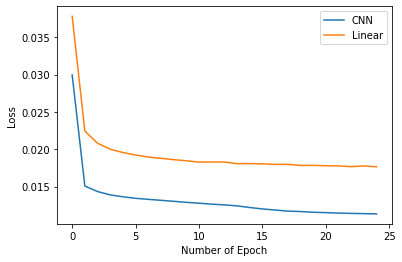

In [46]:
plot_losses(loss_list_cnn, "CNN", loss_list_linear, "Linear")

## Summary
While both networks behave very similar on the same set of data it is important to keep in mind that the classic/linear autoencoder may always give us the average of the input set, or always reconstruct the input set exactly, or combine those two defects in sneaky ways. On the other hand stacked autoencoders are unsupervised models, while CNNs are supervised models. If your data is labeled, you should use CNN for better results.

This is exactly what happens in this specific training set. CNN performs slighty better which is visible while analysing the training loss.